## **Preparo el entorno**

In [ ]:
!pip install pyCompare pingouin BaselineRemoval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!rm -rf marvik-final/
!ls -la

total 16
drwxr-xr-x 1 root root 4096 Aug  6 04:02 .
drwxr-xr-x 1 root root 4096 Aug  6 03:52 ..
drwxr-xr-x 4 root root 4096 Aug  3 20:20 .config
drwxr-xr-x 1 root root 4096 Aug  3 20:21 sample_data


## **Clonamos repositorio**

In [ ]:
# Clonamos el repositorio que contiene el archivo a ser usado:

! git clone https://github.com/tabareperez/marvik-final

# Queda disponible el archivo nic-az.csv para el desarrollo del modelo de predicción para nicotina y azúcar
# 

Cloning into 'marvik-final'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


## **Librerías**

In [ ]:
# Importo las librerías
#
%matplotlib inline

from BaselineRemoval import BaselineRemoval

from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

#plt.style.use('ggplot')

# Librerias para Bland-Altman
import pyCompare
import pingouin as pg

# Fijo una semilla para el generador de números pseudo aleatorios.
np.random.seed(1)
# 
np.set_printoptions(precision=3)

## **Importo los datos**

In [ ]:
# Importamos al dataframe "data" nic-az.csv
#
data = pd.read_csv('./marvik-final/nic-az.csv')

# Revisamos los primeros registros
#
data.head()

,Sample ID,950,955,960,965,970,975,980,985,990,...,1620,1625,1630,1635,1640,1645,1650,Product Name,NIC,AZ
0,64127,0.171832,0.167635,0.163632,0.159960,0.156364,0.152704,0.149213,0.145870,0.142653,...,0.170383,0.169234,0.168183,0.167268,0.166693,0.166397,0.166621,BY-TOSTADO,3.42,2.3
1,64128,0.158099,0.154269,0.150645,0.147355,0.144167,0.140856,0.137698,0.134655,0.131734,...,0.168755,0.167463,0.166241,0.165137,0.164441,0.163915,0.163921,BY-TOSTADO,3.15,2.9
2,64129,0.147801,0.144223,0.140782,0.137600,0.134641,0.131533,0.128556,0.125714,0.122948,...,0.164203,0.162931,0.161710,0.160644,0.159961,0.159489,0.159452,BY-TOSTADO,3.17,2.6
3,64130,0.156667,0.152860,0.149220,0.145874,0.142716,0.139439,0.136297,0.133269,0.130398,...,0.165463,0.164344,0.163276,0.162332,0.161748,0.161411,0.161582,BY-TOSTADO,3.58,2.8
4,64131,0.156585,0.152820,0.149251,0.145938,0.142771,0.139458,0.136344,0.133299,0.130426,...,0.169477,0.168239,0.167031,0.165951,0.165254,0.164829,0.164926,BY-TOSTADO,3.56,2.9


## **Extraigo los espectros NIR (FEATURES)**

In [ ]:
features = data.drop(columns=['Sample ID', 'Product Name', 'NIC', 'AZ'],axis=1)
features.head()

,950,955,960,965,970,975,980,985,990,995,...,1605,1610,1615,1620,1625,1630,1635,1640,1645,1650
0,0.171832,0.167635,0.163632,0.159960,0.156364,0.152704,0.149213,0.145870,0.142653,0.139435,...,0.175053,0.173343,0.171665,0.170383,0.169234,0.168183,0.167268,0.166693,0.166397,0.166621
1,0.158099,0.154269,0.150645,0.147355,0.144167,0.140856,0.137698,0.134655,0.131734,0.128839,...,0.173823,0.171989,0.170202,0.168755,0.167463,0.166241,0.165137,0.164441,0.163915,0.163921
2,0.147801,0.144223,0.140782,0.137600,0.134641,0.131533,0.128556,0.125714,0.122948,0.120195,...,0.169248,0.167431,0.165657,0.164203,0.162931,0.161710,0.160644,0.159961,0.159489,0.159452
3,0.156667,0.152860,0.149220,0.145874,0.142716,0.139439,0.136297,0.133269,0.130398,0.127533,...,0.170102,0.168402,0.166732,0.165463,0.164344,0.163276,0.162332,0.161748,0.161411,0.161582
4,0.156585,0.152820,0.149251,0.145938,0.142771,0.139458,0.136344,0.133299,0.130426,0.127535,...,0.174491,0.172663,0.170898,0.169477,0.168239,0.167031,0.165951,0.165254,0.164829,0.164926


## **Gráficos de los primeros 20 espectros del set que conforman las features del problema**

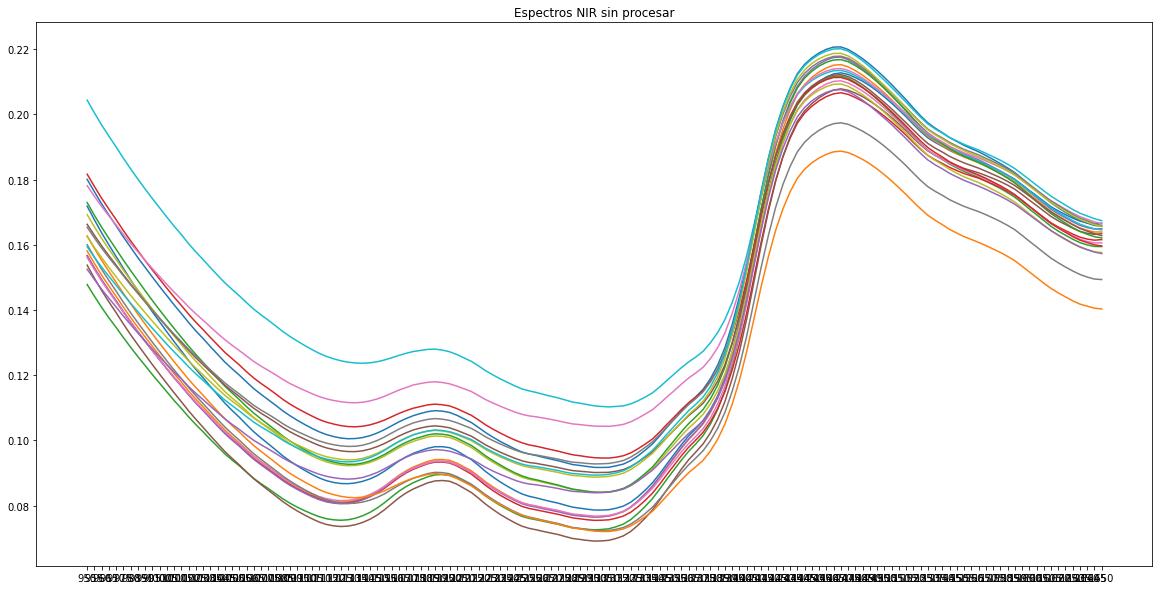

In [ ]:
# Ploteo los primeros 20 espectros crudos.
plt.rcParams["figure.figsize"] = (20,10)
plt.title('Espectros NIR sin procesar')
for i in range(20):
  spec = features.iloc[i,:]
  plt.plot(spec)

plt.show()

## **Target: AZÚCAR**

In [ ]:
target_az = data[['AZ']]
target_az.head()

,AZ
0,2.3
1,2.9
2,2.6
3,2.8
4,2.9


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad268b55d0>]],
      dtype=object)

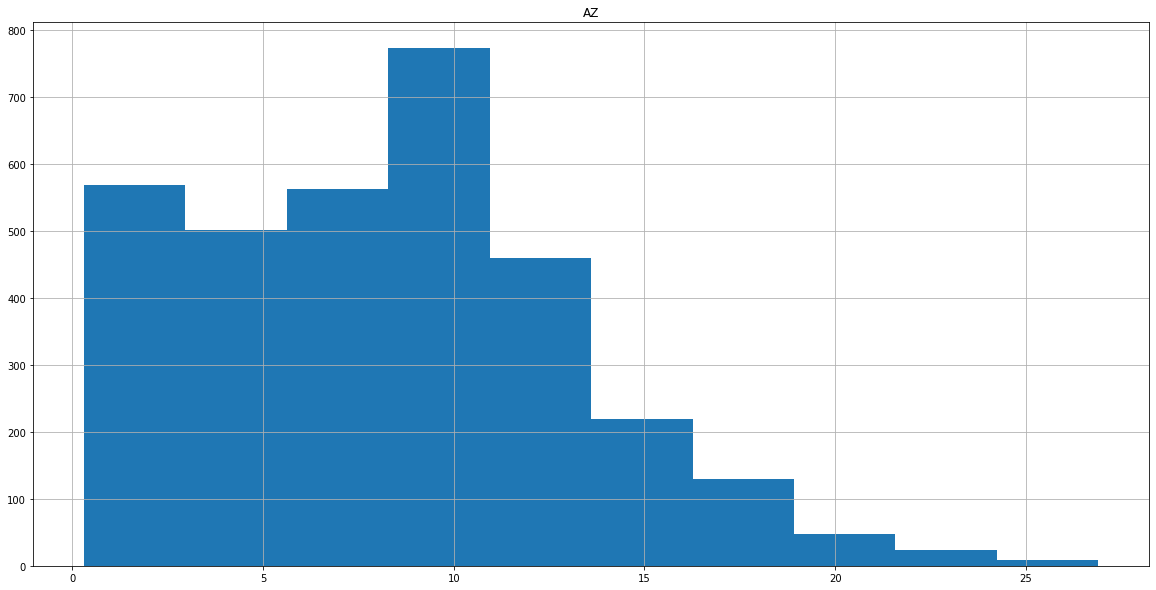

In [ ]:
target_az.hist()

## **Preparo los sets de entrenamiento y test**

In [ ]:
train_features, test_features, train_target_az, test_target_az = train_test_split(features, target_az, test_size=0.3, random_state=0)

## **Construyo el modelo para AZÚCAR**

In [ ]:
model = MLPRegressor(hidden_layer_sizes=(141, 64, 32, 16, 8, 4, 2, 1),
                     max_iter = 200,activation = 'relu',
                     solver = 'adam')
model.fit(train_features, train_target_az)
print(model)

MLPRegressor(hidden_layer_sizes=(141, 64, 32, 16, 8, 4, 2, 1))


## **Predecimos la nicotina con el modelo generado**

In [ ]:
expected_y  = test_target_az
predicted_y = model.predict(test_features)

## **Evaluamos el modelo y graficamos el valor real contra el predicho**

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(expected_y, predicted_y))  
print('Mean Squared Error:', metrics.mean_squared_error(expected_y, predicted_y))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(expected_y, predicted_y)))
print('R2: ', metrics.r2_score(expected_y, predicted_y))

Mean Absolute Error: 2.1982934734172104
Mean Squared Error: 7.895934917562798
Root Mean Squared Error: 2.8099706257473223
R2:  0.6780158154928917


## **Función de pérdida del modelo**

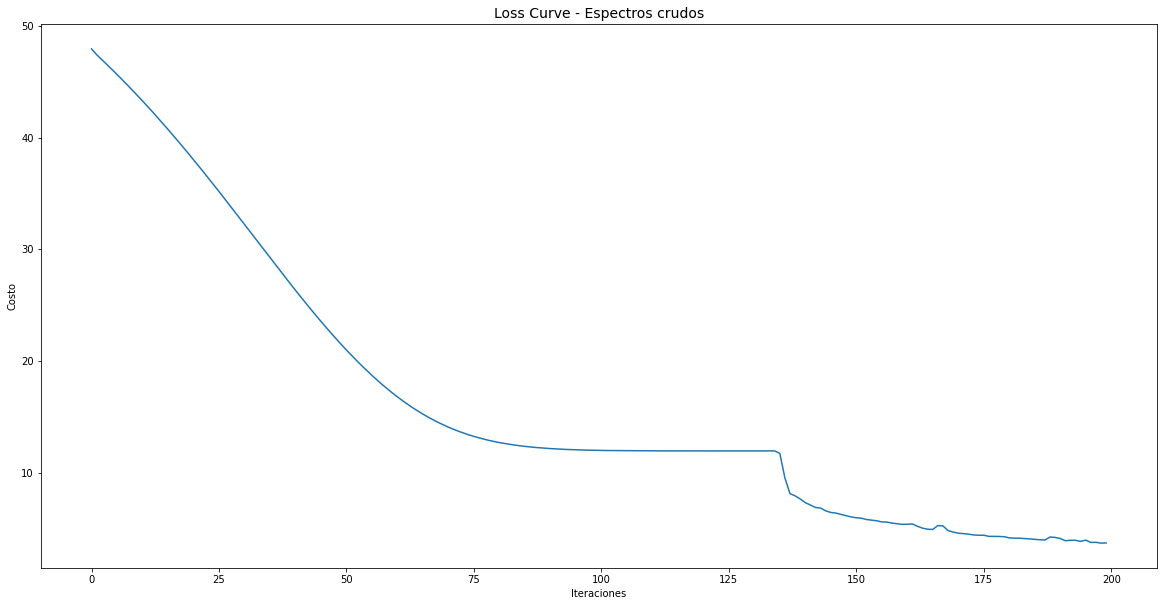

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(model.loss_curve_)
plt.title("Loss Curve - Espectros crudos", fontsize=14)
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.show()

## **Corrijo línea de base de los espectros**

In [ ]:
# Armo la matriz de espectros corregidos por línea de base
polynomial_degree=2 # Only needed for Modpoly and IModPoly algorithm
specObj=BaselineRemoval(features)

# Para recorrer todos los espectros: len(data)
features_bl = features
for i in range(len(data)):
  spec = features.iloc[i,:]
  specObj=BaselineRemoval(spec)
  spec_corregido = specObj.ModPoly(polynomial_degree)
  features_bl.loc[i] = spec_corregido

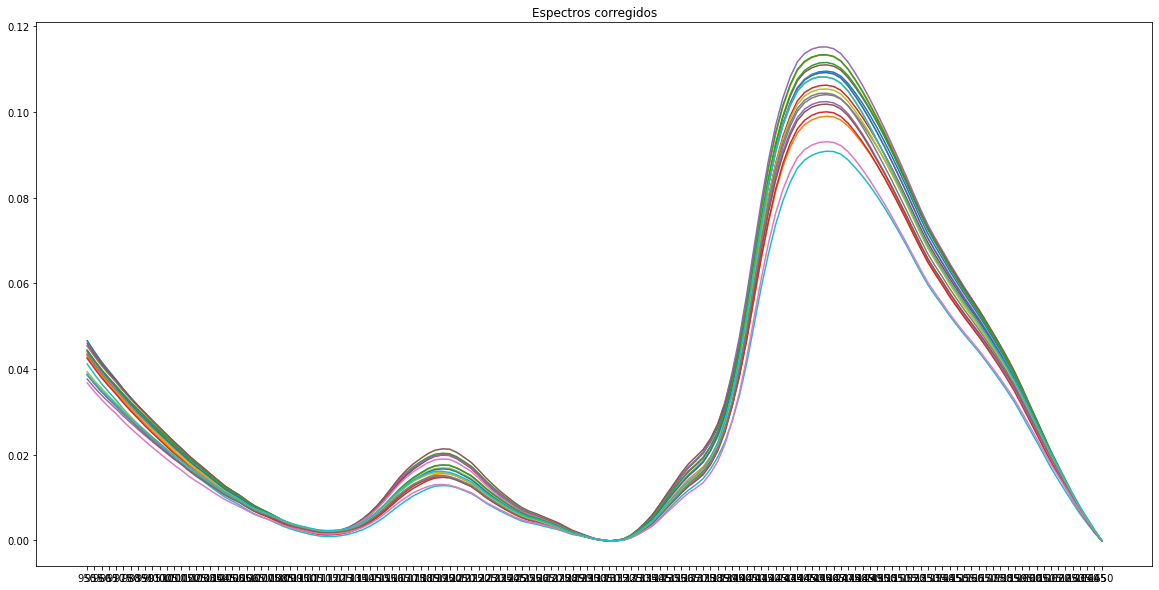

In [ ]:
# Ploteo los primeros 20 espectros con corrección de línea de base.
plt.rcParams["figure.figsize"] = (20,10)
plt.title('Espectros corregidos')
for i in range(20):
  spec_corregido = features_bl.iloc[i,:]
  plt.plot(spec_corregido)

plt.show()

## **Preparo los sets de entrenamiento y test**
Tomamos un 30% de los datos para test.

In [ ]:
train_features, test_features, train_target_az, test_target_az = train_test_split(features_bl, target_az, test_size=0.3, random_state=0)

In [ ]:
# Generamos el modelo
model = model = MLPRegressor(hidden_layer_sizes=((141, 64, 32, 16, 8, 4, 2, 1)),
                     max_iter = 200,activation = 'relu',
                     solver = 'adam')
model.fit(train_features, train_target_az)
print(); print(model)


MLPRegressor(hidden_layer_sizes=(141, 64, 32, 16, 8, 4, 2, 1))


## **Predecimos el AZÚCAR con el modelo generado**

In [ ]:
# Hacemos predicciones con el modelo generado
expected_y  = test_target_az
predicted_y = model.predict(test_features)

## **Evaluamos el modelo y graficamos el valor real contra el predicho**

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(expected_y, predicted_y))  
print('Mean Squared Error:', metrics.mean_squared_error(expected_y, predicted_y))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(expected_y, predicted_y)))
print('R2: ', metrics.r2_score(expected_y, predicted_y))

Mean Absolute Error: 1.3943843622266123
Mean Squared Error: 3.5091549272705
Root Mean Squared Error: 1.8732738527162813
R2:  0.8569020135851054


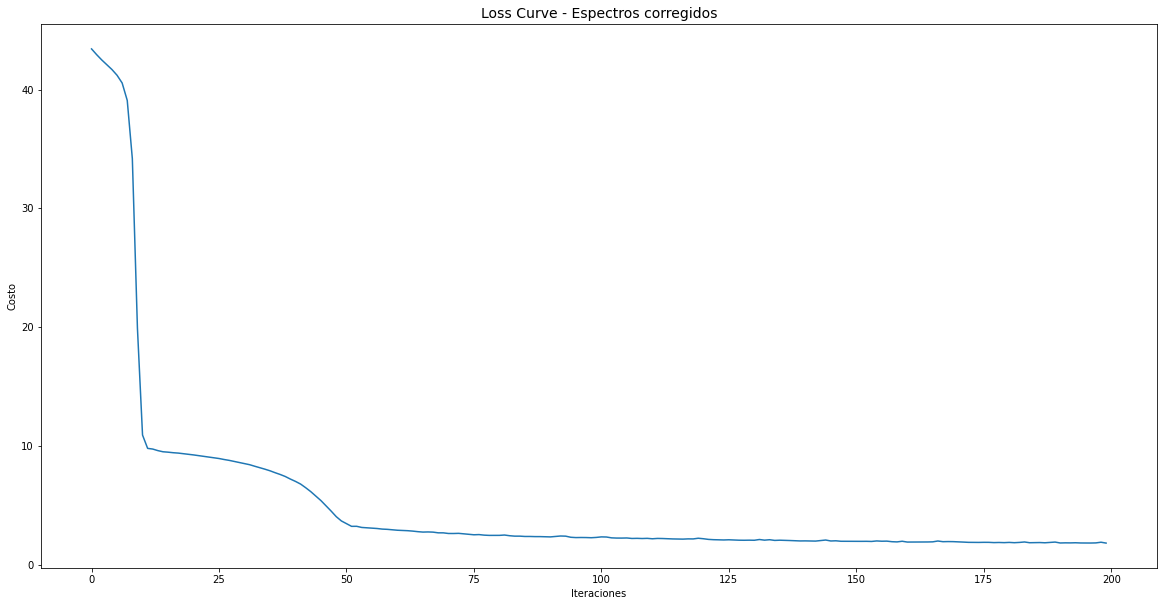

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(model.loss_curve_)
plt.title("Loss Curve - Espectros corregidos", fontsize=14)
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.show()